# Sports Activity Detection

#### 1. Download Dataset and Understand the Format

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# # from google.colab import drive

# # drive.mount('/content/drive')

# # data_path = '/content/drive/My Drive/data'

data_path = 'C:/Users/dell/Downloads/data/data'
# data_path = 'data'

def preprocess_and_reduce_dimension(data_path):
    X_train_means, X_val_means = [], []
    X_train_flattened, X_val_flattened = [], []
    y_train, y_val = [], []

    for activity_folder in os.listdir(data_path):
        if '.DS_Store' in activity_folder: continue
        activity_folder_path = os.path.join(data_path, activity_folder)
        activity_label = int(activity_folder[1:])  # Extract the numeric part from the folder name
        for subject_folder in os.listdir(activity_folder_path):
            subject_folder_path = os.path.join(activity_folder_path, subject_folder)
            segment_files = os.listdir(subject_folder_path)
            for i, segment_file in enumerate(segment_files):
                segment_file_path = os.path.join(subject_folder_path, segment_file)
                segment_data = np.loadtxt(segment_file_path, delimiter=',')

                if i < 48:
                    # Considering only training data
                    segment_mean = np.mean(segment_data, axis=0)
                    X_train_means.append(segment_mean)
                    segment_flattened = segment_data.flatten()
                    X_train_flattened.append(segment_flattened)
                    y_train.append(activity_label)
                else:
                    # Consider only validation data
                    segment_mean = np.mean(segment_data, axis=0)
                    X_val_means.append(segment_mean)
                    segment_flattened = segment_data.flatten()
                    X_val_flattened.append(segment_flattened)
                    y_val.append(activity_label)

    X_train_means = np.array(X_train_means)
    X_val_means = np.array(X_val_means)
    X_train_flattened = np.array(X_train_flattened)
    X_val_flattened = np.array(X_val_flattened)
    y_train = np.array(y_train) - 1
    y_val = np.array(y_val) - 1

    return X_train_means, X_val_means, X_train_flattened, X_val_flattened, y_train, y_val

X_train_means, X_val_means, X_train_flattened, X_val_flattened, y_train, y_val = preprocess_and_reduce_dimension(data_path)

print("Mean-based Preprocessed Training Data Shape:", X_train_means.shape)
print("Mean-based Preprocessed Validation Data Shape:", X_val_means.shape)
print("Flattened Preprocessed Training Data Shape:", X_train_flattened.shape)
print("Flattened Preprocessed Validation Data Shape:", X_val_flattened.shape)
print("Training Labels Shape:", y_train.shape)
print("Validation Labels Shape:", y_val.shape)

# np.set_printoptions(threshold=np.inf)
# print(y_val)

Mean-based Preprocessed Training Data Shape: (7296, 45)
Mean-based Preprocessed Validation Data Shape: (1824, 45)
Flattened Preprocessed Training Data Shape: (7296, 5625)
Flattened Preprocessed Validation Data Shape: (1824, 5625)
Training Labels Shape: (7296,)
Validation Labels Shape: (1824,)


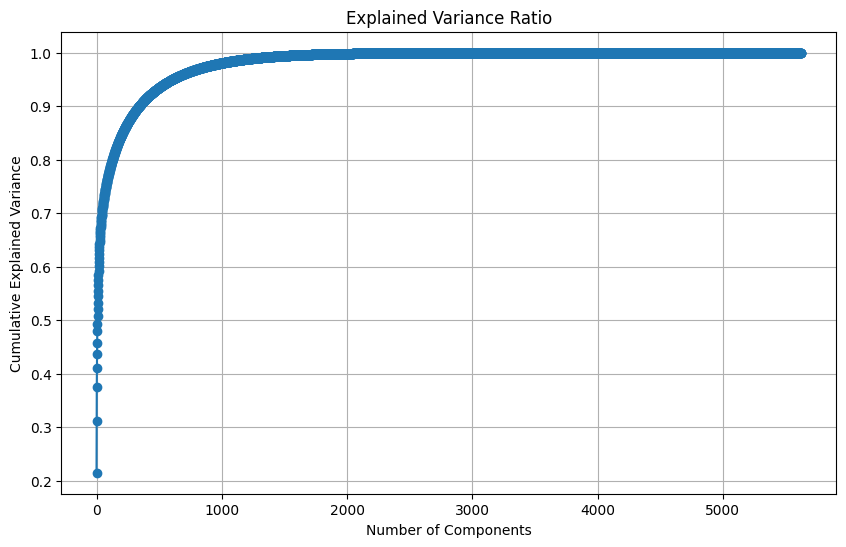

Optimal number of components for 90% variance: 342
(7296, 342)
(1824, 342)


In [3]:
cov_matrix = np.cov(X_train_flattened, rowvar=False)
pca = PCA()
pca.fit(X_train_flattened)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.grid(True)
plt.show()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_num_components = np.argmax(cumulative_variance >= 0.90) + 1
print("Optimal number of components for 90% variance:",optimal_num_components)

pca_optimal = PCA(n_components=optimal_num_components)
X_train_flattened= pca_optimal.fit_transform(X_train_flattened)
X_val_flattened = pca_optimal.transform(X_val_flattened)
print(X_train_flattened.shape)
print(X_val_flattened.shape)


#### 2. Clustering Using K-Means


In [16]:
import numpy as np
import math

def get_contingency_matrix(clustering, truth, n_classes, n_clusters):
    cont_mat = np.zeros((n_classes, n_clusters))
    for i in range(len(clustering)):
        xi = truth[i]
        yi = clustering[i]
        cont_mat[xi][yi] += 1
    return cont_mat

def conditional_entropy(clustering, truth, n_classes, n_clusters):
    cont_mat = get_contingency_matrix(clustering, truth, n_classes, n_clusters)
    entropy =  0
    for j in range(n_classes):
        for i in range(n_clusters):
            if sum(cont_mat[:, i]) == 0: continue
            pij = cont_mat[j][i] / float(len(clustering))
            pci = sum(cont_mat[:, i]) / float(len(clustering))
            if pij == 0: continue
            entropy -= pij*math.log2(pij / pci)

    return entropy

def f_measure(clustering, truth, n_classes, n_clusters):
    cont_mat = get_contingency_matrix(clustering, truth, n_classes, n_clusters)
    fs = np.zeros(n_clusters)
    for i in range(n_clusters):
        max_j = -1
        if sum(cont_mat[:, i]) == 0: continue
        for j in range(n_classes):
            
            if (max_j == -1 or cont_mat[j,i] > cont_mat[max_j,i]): max_j = j
        prec = cont_mat[max_j,i] / float(sum(cont_mat[:, i]))
        recall = cont_mat[max_j,i] / float(sum(cont_mat[max_j]))
        fs[i] = 2*prec*recall / (prec + recall)
    return sum(fs) / float(n_clusters)       

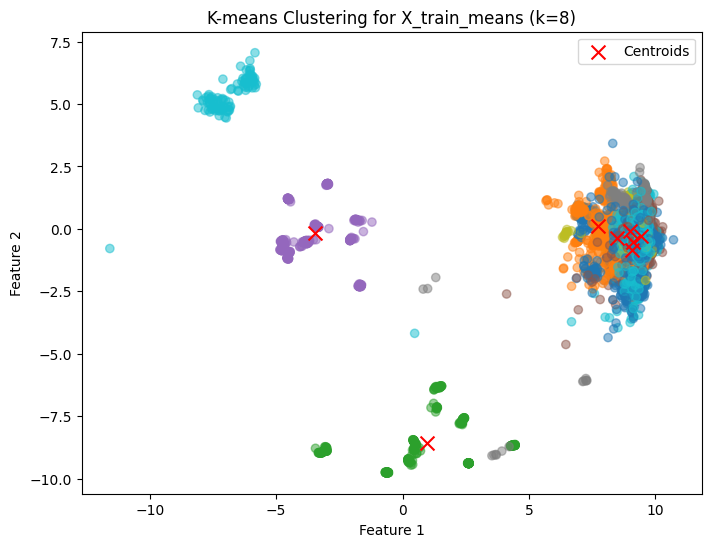

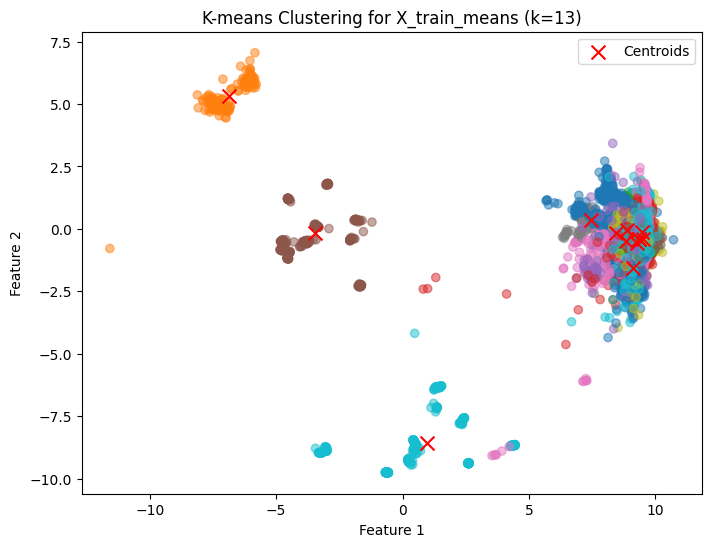

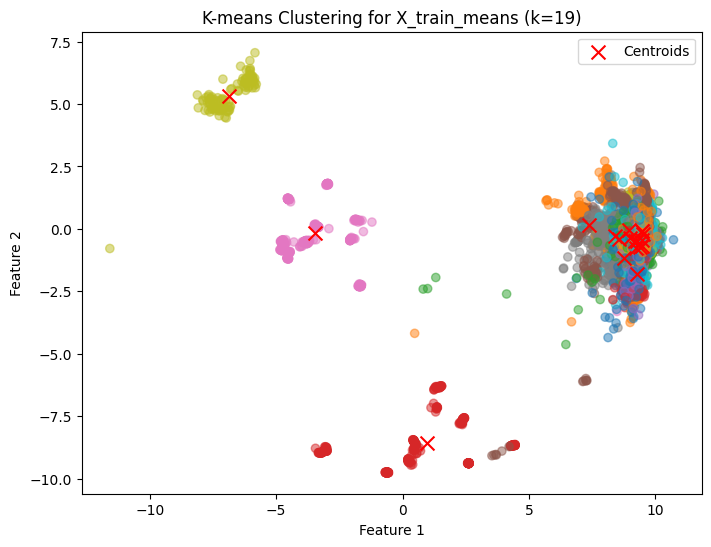

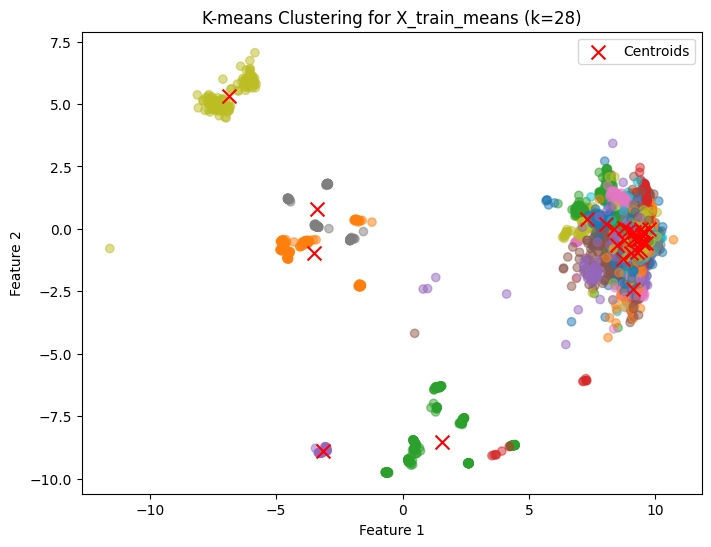

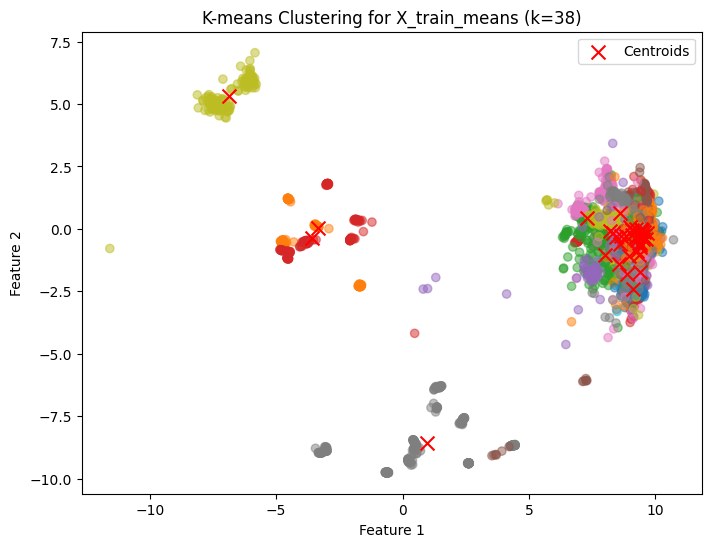

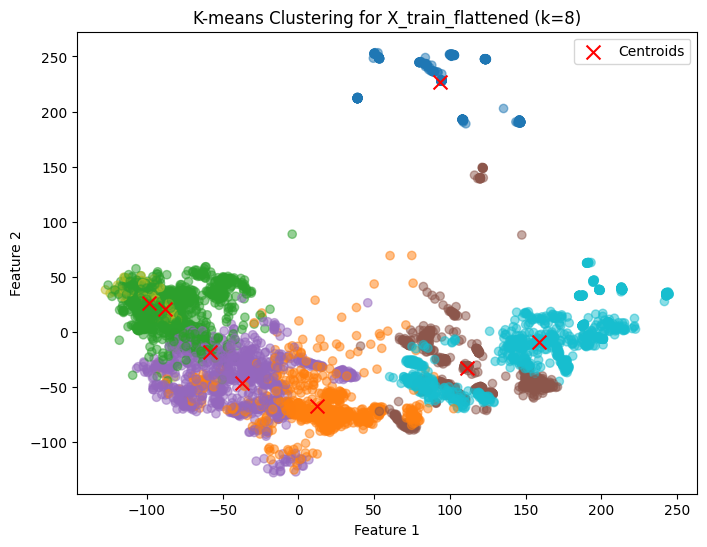

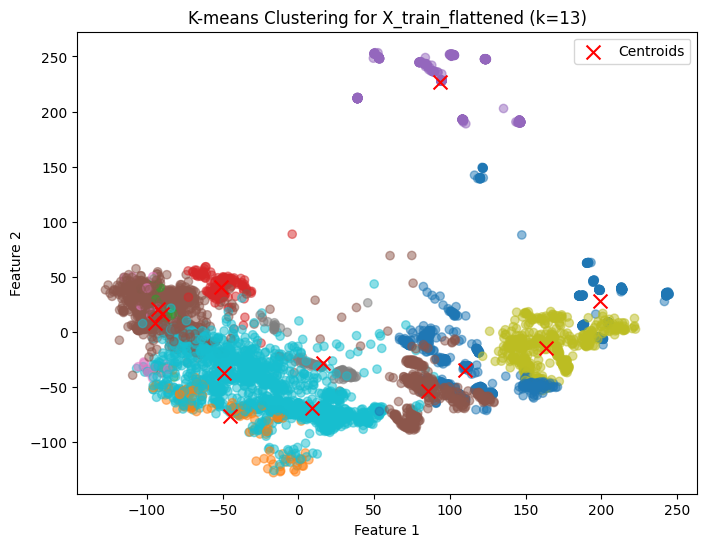

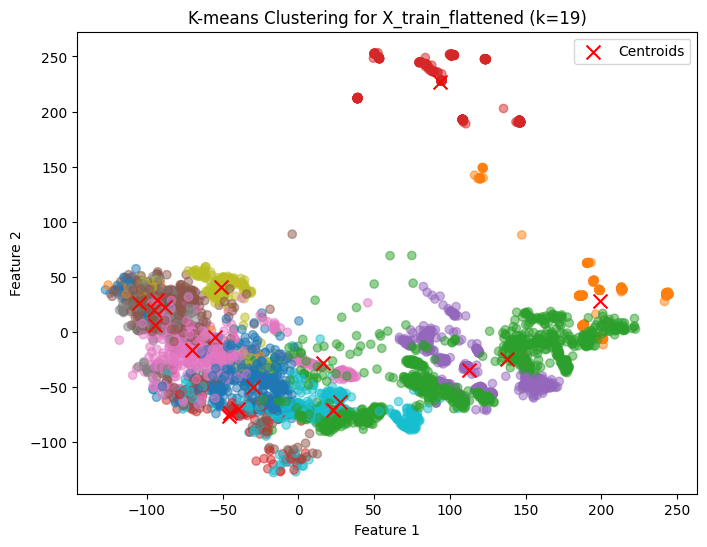

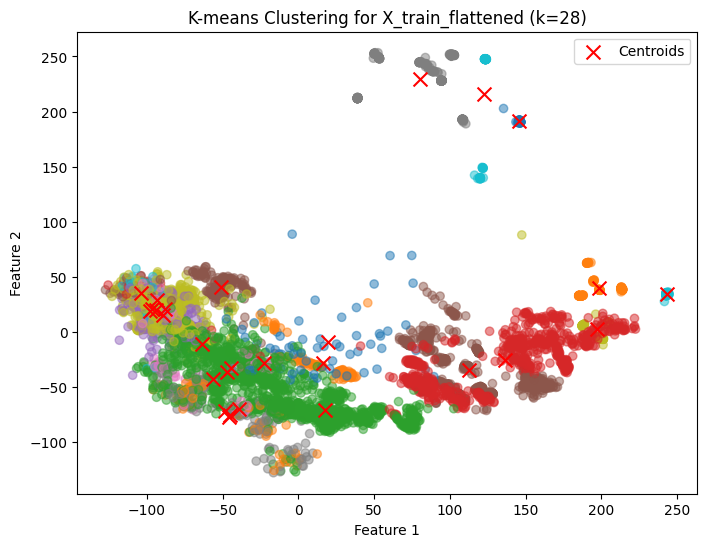

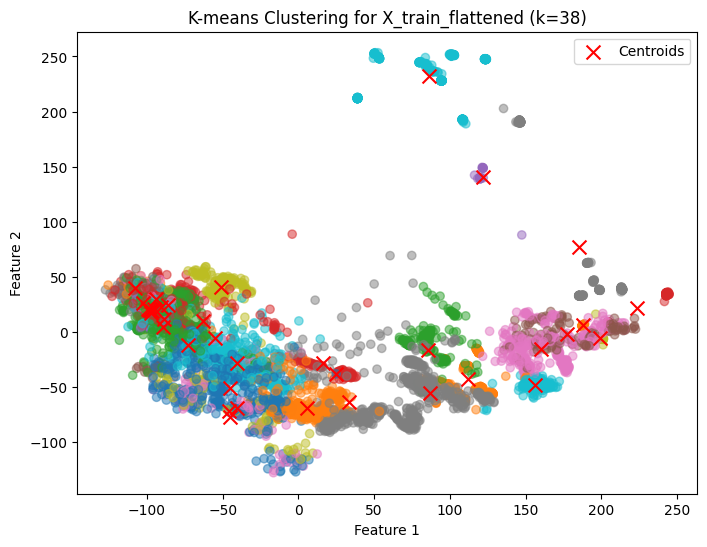

    k  f1 measure means based  f1 measure flattened based
0   8                0.604663                    0.444482
1  13                0.472384                    0.521452
2  19                0.456351                    0.408665
3  28                0.400351                    0.291734
4  38                0.366515                    0.325216
    k  cond entropy measure means based  cond entropy measure flattened based
0   8                          2.341757                              2.651652
1  13                          2.191962                              2.167580
2  19                          1.881138                              2.035312
3  28                          1.691865                              2.094977
4  38                          1.299502                              1.644769


In [17]:
#training function
def kmeans(X,n_clusters,max_iter=300):
    centroids = X[np.random.choice(X.shape[0],n_clusters,replace=False)]
    for _ in range(max_iter):
        distances =np.sqrt(((X-centroids[:,np.newaxis])**2).sum(axis=2))
        labels=np.argmin(distances, axis=0)
        new_centroids=np.zeros_like(centroids)
        for i in range(n_clusters):
          if np.sum(labels == i) > 0:
            new_centroids[i]=np.mean(X[labels == i], axis=0)
        if np.allclose(centroids, new_centroids):
            break  
        centroids = new_centroids
    return labels, centroids

#prediction function
def predict_labels(X_val,centroids):
    distances = np.sqrt(((X_val - centroids[:, np.newaxis])**2).sum(axis=2))
    labels = np.argmin(distances,axis=0)
    return labels


k_values = [8,13,19,28,38]
datasets = [(X_train_means, 'X_train_means'), (X_train_flattened, 'X_train_flattened')]

means_measures_f1=[]
means_measures_ent=[]

flattened_measures_f1=[]
flattened_measures_ent=[]


#visualizing pairs of attributes & comparing the 2 method using the 4 ways of measurement 
for X, dataset_name in datasets:
    for k in k_values:
        labels,centroids=kmeans(X,k)
        if dataset_name=='X_train_means':
          means_measures_f1.append(f_measure(predict_labels(X_val_means,centroids),y_val,19,k))
          means_measures_ent.append(conditional_entropy(predict_labels(X_val_means,centroids),y_val,19,k))
        else:
          flattened_measures_f1.append(f_measure(predict_labels(X_val_flattened,centroids),y_val,19,k))
          flattened_measures_ent.append(conditional_entropy(predict_labels(X_val_flattened,centroids),y_val,19,k))

        plt.figure(figsize=(8,6))
        plt.scatter(X[:,0], X[:,1],c=labels,cmap='tab10',alpha=0.5)
        plt.scatter(centroids[:, 0], centroids[:,1], c='red',marker='x',s=100, label='Centroids')
        plt.title(f'K-means Clustering for {dataset_name} (k={k})')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()


df1 = pd.DataFrame(columns=['k', 'f1 measure means based', 'f1 measure flattened based'])
df2 = pd.DataFrame(columns=['k', 'cond entropy measure means based', 'cond entropy measure flattened based'])




df1['k'] = k_values
df1['f1 measure means based'] = means_measures_f1
df1['f1 measure flattened based'] = flattened_measures_f1

df2['k'] = k_values
df2['cond entropy measure means based'] = means_measures_ent
df2['cond entropy measure flattened based'] = flattened_measures_ent

print(df1)
print(df2)

#### 3. Clustering Using Normalized Cut

In [5]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import networkx as nx

def normalized_cut(X, n_clusters):
    dist_matrix = pairwise_distances(X, metric='euclidean')
    similarity_matrix = np.exp(-dist_matrix ** 2 / (2. * np.std(dist_matrix) ** 2))
    G = nx.from_numpy_array(similarity_matrix)
    D = np.diag(np.array(G.degree(weight='weight'))[:, -1])
    L = nx.laplacian_matrix(G).toarray()
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    normalized_laplacian = np.dot(D_sqrt_inv, np.dot(L, D_sqrt_inv))
    eigenvalues, eigenvectors = np.linalg.eig(normalized_laplacian)
    k_smallest = eigenvectors[:, :n_clusters]
    k_smallest_normalized = np.divide(k_smallest, np.apply_along_axis(np.linalg.norm, 1, k_smallest)[:, np.newaxis])
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(k_smallest_normalized)
    return kmeans.labels_

In [ ]:
k_values = [8, 13, 19, 28, 38]
datasets = [(X_train_means, 'X_train_means'), (X_train_flattened, 'X_train_flattened')]

#visualizing 2 attributes for visualization
for X, dataset_name in datasets:
    for k in k_values:
        labels = normalized_cut(X, k)
        plt.figure(figsize=(8,6))
        plt.scatter(X[:,0], X[:,1],c=labels,cmap='tab20',alpha=0.5)
        plt.title(f'Normalized Cut Clustering for {dataset_name} (k={k})')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()


#### 4. Evaluation

In [6]:
# Precision
def get_precision(y_true, y_pred):
    unique_labels = np.unique(y_true)
    true_positives = false_positives = 0
    for label in unique_labels:
        pred_indices = np.where(y_pred == label)
        true_lables = y_true[pred_indices[0]]
        true_counts = np.bincount(true_lables)
        if not true_counts.size:
            continue
        true_positives += np.max(true_counts)
        false_positives += np.sum(true_counts) - np.max(true_counts)
    return true_positives / (true_positives + false_positives)

In [7]:
# Recall
def get_recall(y_true, y_pred):
    unique_labels = np.unique(y_true)
    true_positives = false_negatives = 0
    for label in unique_labels:
        true_indices = np.where(y_true == label)
        pred_lables = y_pred[true_indices[0]]
        pred_counts = np.bincount(pred_lables)
        if not pred_counts.size:
            continue
        true_positives += np.max(pred_counts)
        false_negatives += np.sum(pred_counts) - np.max(pred_counts)
    return true_positives / (true_positives + false_negatives)

In [8]:
# F1 Score
def get_f1_score(y_true, y_pred):
    p = get_precision(y_true, y_pred)
    r = get_recall(y_true, y_pred)
    return 2 * p * r / (p + r)

In [9]:
# Conditional Entropy Evaluation
def conditional_entropy(y_true, y_pred):
    entropy = 0
    for i in np.unique(y_true):
        p_y = np.sum(y_true == i) / len(y_true)
        for j in np.unique(y_pred):
            p_y_pred = np.sum(y_pred == j) / len(y_pred)
            p_y_y_pred = np.sum((y_true == i) & (y_pred == j)) / len(y_true)
            if p_y_y_pred != 0:
                entropy += p_y_y_pred * np.log2(p_y_y_pred / (p_y * p_y_pred))
    return -entropy

In [66]:
# Test with builtin KMeans (Temporarily)
from sklearn.cluster import KMeans
k = 19
km = KMeans(n_clusters=k, random_state=0)
km.fit(X_train_flattened)
centroids = km.cluster_centers_
labels = km.labels_

# Evaluate
y_true = y_val
y_pred = km.predict(X_val_flattened)

ce = conditional_entropy(y_true, y_pred)
# print("Conditional Entropy:", ce)

print(y_true)
print(y_pred)

p = get_precision(y_true, y_pred)
r = get_recall(y_true, y_pred)
f1 = get_f1_score(y_true, y_pred)

# # Test with Built-in evaluation functions
from sklearn.metrics import precision_score, recall_score, f1_score, normalized_mutual_info_score
print("Precision (ORIGINAL):", precision_score(y_true, y_pred, average='macro'))
print("Precision (NEW):", p)
print()
print("Recall (ORIGINAL):", recall_score(y_true, y_pred, average='macro'))
print("Recall (NEW):", r)
print()
print("F1 Score (ORIGINAL):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (NEW):", f1)

print("Conditional Entropy (NEW):", ce)


[ 5  5  5 ... 12 12 12]
[ 1  1  1 ...  8  5 17]
Precision (ORIGINAL): 0.0993988684582744
Precision (NEW): 0.4303385416666667

Recall (ORIGINAL): 0.04114583333333333
Recall (NEW): 0.7066885964912281

F1 Score (ORIGINAL): 0.0533254055589081
F1 Score (NEW): 0.534930662286914
Conditional Entropy (NEW): -2.2228349336497844


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 5. New Clustering Algorithm : DBSCAN

In [4]:
import numpy as np
from sklearn.metrics import pairwise_distances

def DBSCAN(data, eps, min_pts):
    adj_mat = pairwise_distances(data, metric='euclidean')
    n = adj_mat.shape[0]
    clustering = np.zeros(n, dtype=np.int64)
    core = set()
    neighborhoods = []
    #Find core points and neighborhoods
    for i in range(n):
        clustering[i] = -1
        neighbors = np.where(adj_mat[i] <= eps)[0]
        neighbors = neighbors[neighbors != i]
        neighborhoods.append(neighbors)
        if len(neighborhoods[i]) >= min_pts:
            core.add(i)
    #Expand clusters
    k = 0
    for x_idx in core:
        if clustering[x_idx] != -1:
            continue
        clustering[i] = k
        #Add density connected points to cluster
        density_connected(x_idx, k, neighborhoods, clustering, core)
        k += 1
    #Clustering outliers
    outlier_count = 0
    for i in range(n):
        if clustering[i] == -1:
            outlier_count += 1
            nearest = -1
            for j in range(0, n):
                if clustering[j] != -1:
                    if nearest == -1 or adj_mat[i, j] < adj_mat[i, nearest]: nearest = j
            clustering[i] = clustering[nearest]
    print(f"DBSCAN: {outlier_count} outliers were clustered with 1NN.")
    
    return clustering, k, outlier_count #Clustered data, number of clusters         


def density_connected(x_idx, k, neighborhoods, clustering, core):
    queue = [(x_idx, k)]
    while len(queue) > 0:
        x_idx, k = queue.pop(0)
        for j in neighborhoods[x_idx]:
                if clustering[j] == -1:
                    clustering[j] = k
                    if j in core:
                        queue.append((j, k))
    

#### Grid searching for good parameters

In [32]:
import Evaluation as ev
datasets = [(X_val_means, 'X_val_means'), (X_val_flattened, 'X_val_flattened')]

min_eps, max_eps = 0.5, 8
min_minpts, max_minpts = 3, 60
eps_inc, minpts_inc = 0.2, 3
scores = {}
for X, dataset_name in datasets:
    scores[dataset_name] = []
    eps = min_eps
    minpts = min_minpts
    print(f"\n\nExamining dataset {dataset_name}")
    while eps <= max_eps or minpts <= max_minpts:
        print(f"\nEps={eps}, min_pnts={minpts}")
        dbscan_y, no_clusters, outlier_count = DBSCAN(X, eps, minpts)
        eps += eps_inc
        if eps > max_eps and minpts <= max_minpts:
            eps = min_eps
            minpts += minpts_inc
        print(f"No. of clusters={no_clusters}")
        if no_clusters <= 1: continue
        print(f"Precision={get_precision(y_val, dbscan_y)}")
        print(f"Recall={get_recall(y_val, dbscan_y)}")
        f_score, entropy = ev.f_measure(dbscan_y, y_val, 19, no_clusters), ev.conditional_entropy(dbscan_y, y_val, 19, no_clusters)
        print(f"F1 Score={f_score}")
        print(f"Conditional Entropy={entropy}")
        scores[dataset_name].append((eps, minpts, f_score, entropy, no_clusters, outlier_count))


            



Examining dataset X_val_means

Eps=0.5, min_pnts=3
DBSCAN: 1249 outliers were clustered with 1NN.
No. of clusters=52
Precision=0.7134831460674157
Recall=0.42543859649122806
F1 Score=0.26330535097989477
Conditional Entropy=1.6668780176998985

Eps=0.7, min_pnts=3
DBSCAN: 911 outliers were clustered with 1NN.
No. of clusters=99
Precision=0.9827586206896551
Recall=0.2324561403508772
F1 Score=0.23902285051074043
Conditional Entropy=0.6875336389729333

Eps=0.8999999999999999, min_pnts=3
DBSCAN: 655 outliers were clustered with 1NN.
No. of clusters=107
Precision=1.0
Recall=0.21271929824561403
F1 Score=0.24218817835938414
Conditional Entropy=0.5302884526698222

Eps=1.0999999999999999, min_pnts=3
DBSCAN: 513 outliers were clustered with 1NN.
No. of clusters=122
Precision=1.0
Recall=0.19298245614035087
F1 Score=0.2326506890774368
Conditional Entropy=0.36565821861858794

Eps=1.2999999999999998, min_pnts=3
DBSCAN: 385 outliers were clustered with 1NN.
No. of clusters=130
Precision=1.0
Recall=0.1

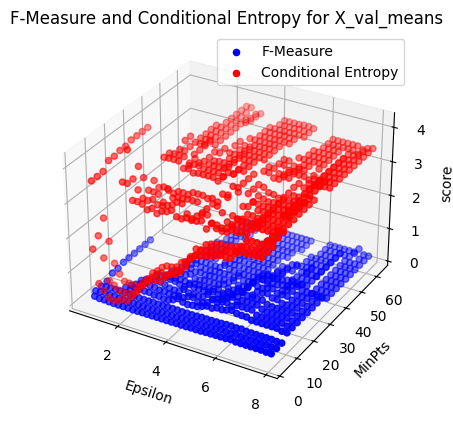

<Figure size 1000x600 with 0 Axes>

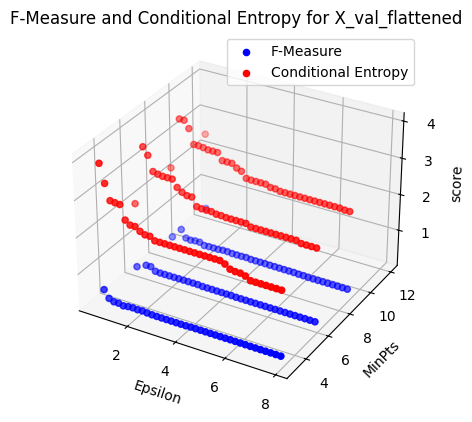

<Figure size 1000x600 with 0 Axes>

In [31]:
for dataset in scores.keys():
    ax = plt.figure().add_subplot(projection='3d')
    plt.figure(figsize=(10,6))
    xs = [i[0] for i in scores[dataset]]
    ys = [i[1] for i in scores[dataset]]
    zs = [i[2] for i in scores[dataset]]
    ax.scatter(xs, ys, zs, color='blue', label="F-Measure")
    zs = [i[3] for i in scores[dataset]]
    ax.scatter(xs, ys, zs, color='red', label="Conditional Entropy")
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('MinPts')
    ax.set_zlabel('score')
    ax.legend()
    ax.set_title(f'F-Measure and Conditional Entropy for {dataset}')
    # ax.view_init(elev=0., azim=-90, roll=0)
    plt.show()

for dataset in scores.keys():
        ax = plt.figure().add_subplot(projection='3d')
        plt.figure(figsize=(10,6))
        xs = [i[0] for i in scores[dataset]]
        ys = [i[1] for i in scores[dataset]]
        zs = [i[4] for i in scores[dataset]]
        ax.scatter(xs, ys, zs, color='blue', label="No. of Clusters")
        ax.set_xlabel('Epsilon')
        ax.set_ylabel('MinPts')
        ax.set_zlabel('score')
        ax.legend()
        ax.set_title(f'Number of clusters for {dataset}')
        # ax.view_init(elev=0., azim=-90, roll=0)
        plt.show()

#### Keep clusters close to 19

In [59]:
import Evaluation as ev
datasets = [(X_val_flattened, 'X_val_flattened'), (X_val_means, 'X_val_means')]

min_eps, max_eps = 0.5, 4
min_minpts, max_minpts = 3, 70
eps_inc, minpts_inc = 0.1, 1


for X, dataset_name in datasets:
    eps = min_eps
    minpts = min_minpts
    print(f"\n\nExamining dataset {dataset_name}")
    while eps <= max_eps and minpts <= max_minpts:
            print(f"\nEps={eps}, min_pnts={minpts}")
            dbscan_y, no_clusters, outlier_count = DBSCAN(X, eps, minpts)
            if no_clusters < 19: #Need to increase number of clusters
                eps += eps_inc
                minpts = minpts - minpts_inc * 2 if minpts - minpts_inc * 2 > 1 else minpts
            else:#Need to decrease number of clusters
                minpts += minpts_inc
            print(f"No. of clusters={no_clusters}")
            if no_clusters <= 1: continue
            print(f"Precision={get_precision(y_val, dbscan_y)}")
            print(f"Recall={get_recall(y_val, dbscan_y)}")
            print(f"F1 Score={ev.f_measure(dbscan_y, y_val, 19, no_clusters)}")
            print(f"Conditional Entropy={ev.conditional_entropy(dbscan_y, y_val, 19, no_clusters)}")



Examining dataset X_val_flattened

Eps=0.5, min_pnts=3
DBSCAN: 1804 outliers were clustered with 1NN.
No. of clusters=2
Precision=0.10526315789473684
Recall=0.9989035087719298
Running fmeasure
F1 Score=0.5475347131847862
Runnign conditional entropy
Conditional Entropy=3.9535894300999503

Eps=0.6, min_pnts=3
DBSCAN: 1768 outliers were clustered with 1NN.
No. of clusters=6
Precision=0.15789473684210525
Recall=0.9528508771929824
Running fmeasure
F1 Score=0.46533847513037657
Runnign conditional entropy
Conditional Entropy=3.659347885061286

Eps=0.7, min_pnts=3
DBSCAN: 1710 outliers were clustered with 1NN.
No. of clusters=12
Precision=0.19736842105263158
Recall=0.8903508771929824
Running fmeasure
F1 Score=0.3439859033414714
Runnign conditional entropy
Conditional Entropy=3.464549603660053

Eps=0.7999999999999999, min_pnts=3
DBSCAN: 1691 outliers were clustered with 1NN.
No. of clusters=13
Precision=0.19736842105263158
Recall=0.8903508771929824
Running fmeasure
F1 Score=0.3209442526570847